## メタン分子の配向を一般的に表現する

メタンは4本の等価なCH結合を持ち対称数が12もある。オイラー角で分子の配向を表現しても、同じ向きかどうかを判断するのは難しい。

そこで、4本の結合の方向を球面調和展開し、その係数で分子の向きを表現することにする。

上に書いたように、$l=3$は正四面体分子に適した、4山4谷分布をもっているので、これでメタンの配向を展開してみる。



In [4]:
import scipy.special
import numpy as np


def euclid_to_euler(x,y,z):
    return np.arctan2((x**2+y**2)**0.5, z), np.arctan2(y, x)


def qlm(l,m,x,y,z):
    """
    球面ベクトルの球面調和関数展開
    """
    theta, phi = euclid_to_euler(x,y,z)
    # print(theta,phi)
    return scipy.special.sph_harm(m, l, phi, theta, out=None).mean()


# ダイヤモンド格子
dia = np.array([[-1,-1,-1],
                [-1,+1,+1],
                [+1,-1,+1],
                [+1,+1,-1]]) / 3**0.5

ax = np.radians(0)
ay = np.radians(0)
az = np.radians(90)

rot_x = np.array([[1.0, 0.0, 0.0],
                  [0.0, np.cos(ax), np.sin(ax)],
                  [0.0,-np.sin(ax), np.cos(ax)]])
rot_y = np.array([[np.cos(ay), 0.0,-np.sin(ay)],
                  [0.0, 1.0, 0.0],
                  [np.sin(ay), 0.0, np.cos(ay)]])
rot_z = np.array([[np.cos(az), np.sin(az), 0.0],
                  [-np.sin(az), np.cos(az), 0.0],
                  [0.0, 0.0, 1.0]])

dia = dia @ rot_x @ rot_y @ rot_z

coeffs = dict()
for l in (3,):
    for m in range(-l, +l+1):
        coeff = 0
        for v in dia:
            coeff += qlm(l, m, *v)
        print((l, m), coeff)
        coeffs[l, m] = coeff



(3, -3) (1.1102230246251565e-16+0j)
(3, -2) -1.573449573137716j
(3, -1) (2.7755575615628914e-17-1.3877787807814457e-17j)
(3, 0) 0j
(3, 1) (-5.551115123125783e-17+0j)
(3, 2) (-1.232595164407831e-32+1.5734495731377158j)
(3, 3) (-5.551115123125783e-17+0j)


/Users/matto/Library/CloudStorage/GoogleDrive-vitroid@gmail.com/My Drive/TheoChem/学生/髙橋/boo/Methane/projection.py:43: RuntimeWarning: divide by zero encountered in divide
  alpha = X / ((1-(2*Y/np.pi)**2)**0.5)


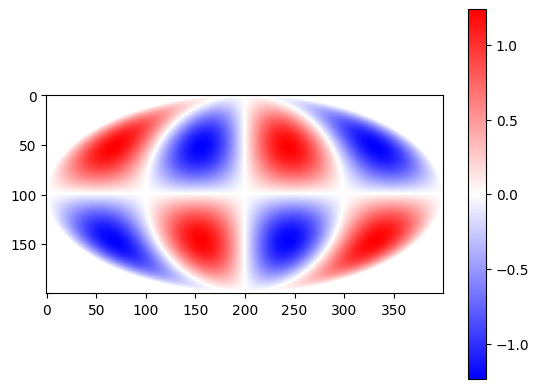

In [7]:
# 係数をたしあわせる


import numpy as np
import matplotlib.pyplot as plt
from projection import mollweide_grid





phi, ido = mollweide_grid(width=400)
# phi, ido = equirectangular_grid(width=400)
theta = np.pi/2 - ido

f = 0
for l in (3,):
    for m in range(-l, +l+1):
        f += scipy.special.sph_harm(m, l, phi, theta, out=None) * coeffs[l, m]

sc = plt.imshow(f.real, cmap='bwr')
# sc = plt.imshow(np.abs(f), cmap='bwr')
plt.colorbar(sc)
plt.show()

実部に出現する数値は全部で4種類。実際には、オイラー角でも2変数で済むので、4つは過剰で、2次元に埋めこめるはずだが、数値の規則性がわからない。

## CHベクトルの配向分布


In [23]:
import gromacs
import numpy as np
import projection
import matplotlib.pyplot as plt


with open("testcase/MethaneAR333-0.gro") as f:
    frames = [frame for frame in gromacs.read_gro(f)]

# エネルギーの緩和に10000ステップ(10 ps)ぐらいかかっているようなので、はじめのほうのデータは捨てる。
frames = frames[20:]

In [24]:
binw = 5 # degrees
bins = np.zeros([180//binw, 360 // binw])

for frame in frames:
    atomname = np.array(frame["atom"])
    
    C = frame["position"][atomname == "C"]
    H = frame["position"][atomname == "H"]
    
    for i in range(4):
        CH = H[i::4] - C
        phi, theta = projection.polar(CH[:,0], CH[:,1], CH[:,2])
        dphi = np.degrees(phi)
        dtheta = np.degrees(theta) # north pole is angle 0
        for p, t in zip(dphi, dtheta):
            binx = int(np.floor(p/binw))
            biny = int(np.floor(t/binw))
            if biny >= 180//binw:
                continue
            bins[biny, binx] += 1

# 全方向均一であったとしても極に近付くほどサンプルが減るため、その分を補正する。
for y in range(180 // binw):
    bins[y, :] /= np.sin(np.radians((y+0.5)*binw))



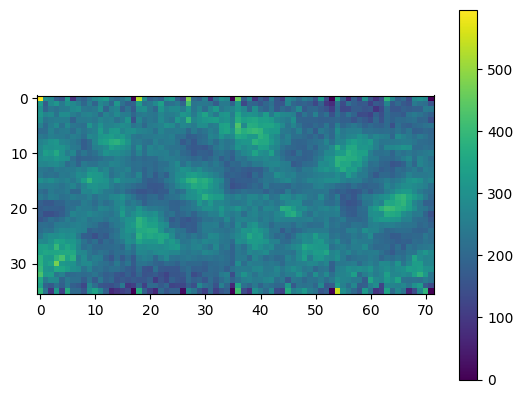

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow(bins, interpolation='none')
fig.colorbar(im)


Bardにお願いしてみた。(そのままでは動かないが、関数のマニュアルをひく手間が省ける)

In [26]:
from plotly.graph_objects import Figure, Surface
import numpy as np

def bard_projector(heightmap_image):
    # Define the heightmap image and its dimensions
    # heightmap_image = ...  # Replace with your image data
    height, width = heightmap_image.shape

    # Define the spherical surface parameters
    radius = heightmap_image
    theta = np.linspace(0, np.pi, height)
    phi = np.linspace(0, 2*np.pi, width)

    # theta, phi = np.meshgrid(theta, phi)
    phi, theta = np.meshgrid(phi, theta)
    print(theta.shape, phi.shape, heightmap_image.shape)
    
    # Calculate the spherical coordinates based on the heightmap
    x = radius * np.sin(theta) * np.cos(phi)
    y = radius * np.sin(theta) * np.sin(phi)
    z = radius * np.cos(theta)

    # Create the plotly surface object
    surface = Surface(x=x, y=y, z=z, surfacecolor=heightmap_image)

    # Set the surface properties
    surface.colorscale = "Viridis"
    surface.lighting = dict(diffuse=0.8, specular=0.2, roughness=0.4)

    # Create the plotly figure
    fig = Figure(data=[surface])

    # Optionally, customize the figure further
    fig.update_layout(
        title="CH orientations",
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False),
            # camera_eye=dict(x=1, y=1, z=2),
        ),
    )

    # Show the plot
    fig.show()

bard_projector(bins)

(36, 72) (36, 72) (36, 72)


MeBでもやってみよう。

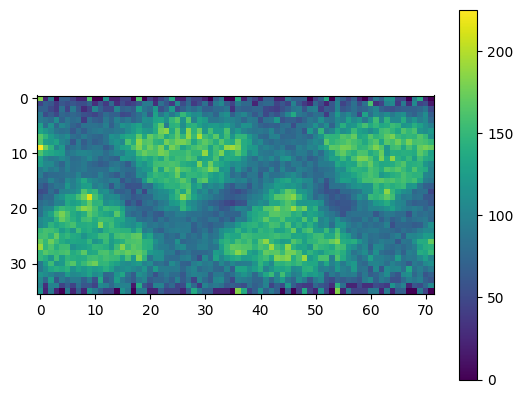

In [29]:
import gromacs
import numpy as np
import projection
import matplotlib.pyplot as plt

# with open("/Users/matto/Downloads/MeA_050-0.gro") as f:
with open("testcase/MeB-0.gro") as f:
    frames = [frame for frame in gromacs.read_gro(f)]

# エネルギーの緩和に10000ステップ(10 ps)ぐらいかかっているようなので、はじめのほうのデータは捨てる。
frames = frames[100:]

binw = 5 # degrees
bins = np.zeros([180//binw, 360 // binw])

for frame in frames:
    atomname = np.array(frame["atom"])
    
    C = frame["position"][atomname == "C"]
    H = frame["position"][atomname == "H"]
    
    for i in range(4):
        CH = H[i::4] - C
        phi, theta = projection.polar(CH[:,0], CH[:,1], CH[:,2])
        dphi = np.degrees(phi)
        dtheta = np.degrees(theta) # north pole is angle 0
        for p, t in zip(dphi, dtheta):
            binx = int(np.floor(p/binw))
            biny = int(np.floor(t/binw))
            if biny >= 180//binw:
                continue
            bins[biny, binx] += 1

# 全方向均一であったとしても極に近付くほどサンプルが減るため、その分を補正する。
for y in range(180 // binw):
    bins[y, :] /= np.sin(np.radians((y+0.5)*binw))

fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow(bins, interpolation='none')
fig.colorbar(im)


In [30]:
bard_projector(bins)

(36, 72) (36, 72) (36, 72)


これは回ってないんじゃないかなあ。高橋君のシミュレーションのなかでMeBが生じたかどうかはわからないけど。

上の図はすべてのメタン分子の、CHの配向分布を示しているが、1分子だけ、あるいは1本のCHだけに注目すれば、分布は違ってみえる可能性がある。

* プラスチックでないなら、単一のCHはいつも同じ方向を向いているだろう。
* 単位胞の中の場所が違うメタンは違う分布を持つと考えるのが自然だ。

最初のメタン分子の4本のCHだけで同じように分布を描くとどうなる?

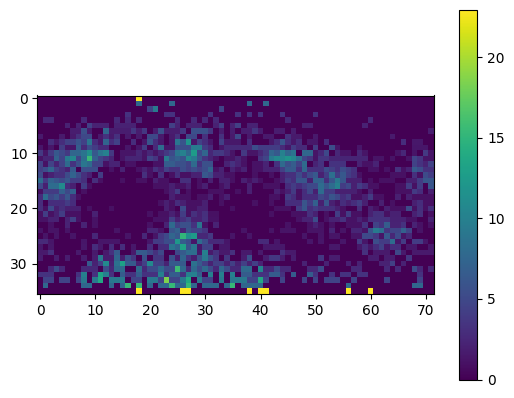

In [55]:
import gromacs
import numpy as np
import projection
import matplotlib.pyplot as plt


with open("testcase/MeB-0.gro") as f:
    frames = [frame for frame in gromacs.read_gro(f)]

# エネルギーの緩和に10000ステップ(10 ps)ぐらいかかっているようなので、はじめのほうのデータは捨てる。
frames = frames[100:]

binw = 5 # degrees
bins = np.zeros([180//binw, 360 // binw])

for frame in frames:
    atomname = np.array(frame["atom"])
    
    C = frame["position"][atomname == "C"]
    H = frame["position"][atomname == "H"]

    # 58 分子ごとに、単位胞内の同じ位置のメタンがある
    label = 5
    # 
    C = C[label::58]
    Hpicks = []
    for i in range(label*4,len(H),58*4):
        Hpicks += [i,i+1,i+2,i+3]
    H = H[Hpicks]
    
    for i in range(4):
        CH = H[i::4] - C
        phi, theta = projection.polar(CH[:,0], CH[:,1], CH[:,2])
        dphi = np.degrees(phi)
        dtheta = np.degrees(theta) # north pole is angle 0
        for p, t in zip(dphi, dtheta):
            binx = int(np.floor(p/binw))
            biny = int(np.floor(t/binw))
            if biny >= 180//binw:
                continue
            bins[biny, binx] += 1

# 全方向均一であったとしても極に近付くほどサンプルが減るため、その分を補正する。
for y in range(180 // binw):
    bins[y, :] /= np.sin(np.radians((y+0.5)*binw))

fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow(bins, interpolation='none')
fig.colorbar(im)


In [56]:
bard_projector(bins)

(36, 72) (36, 72) (36, 72)


MeBのメタンは回ってなさそう。CH分布が広くみえるのは、結晶内の場所ごとの違いを反映しているだけで、動きやすさを反映しているわけではない。

じゃあMeAも。

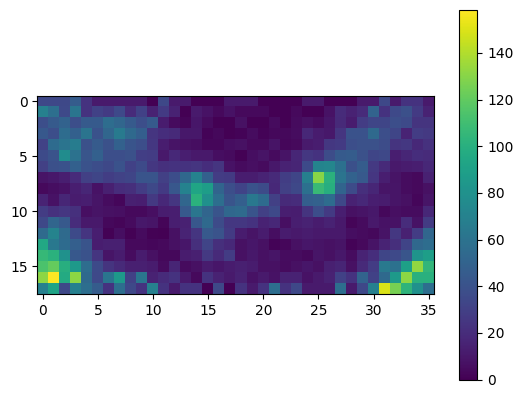

In [61]:
import gromacs
import numpy as np
import projection
import matplotlib.pyplot as plt


with open("testcase/MethaneAR333-0.gro") as f:
    frames = [frame for frame in gromacs.read_gro(f)]

# エネルギーの緩和に10000ステップ(10 ps)ぐらいかかっているようなので、はじめのほうのデータは捨てる。
frames = frames[100:]

binw = 10 # degrees
bins = np.zeros([180//binw, 360 // binw])

for frame in frames:
    atomname = np.array(frame["atom"])
    
    C = frame["position"][atomname == "C"]
    H = frame["position"][atomname == "H"]

    # 21 分子ごとに、単位胞内の同じ位置のメタンがある
    label = 7
    # 炭素は21個ごとに抽出
    C = C[label::21]

    # 水素は84個ごとに4連で抽出したラベルのリストを作り、fancy indexで抽出
    Hpicks = []
    for i in range(label*4,len(H),21*4):
        Hpicks += [i,i+1,i+2,i+3]
    H = H[Hpicks]
    
    for i in range(4):
        CH = H[i::4] - C
        phi, theta = projection.polar(CH[:,0], CH[:,1], CH[:,2])
        dphi = np.degrees(phi)
        dtheta = np.degrees(theta) # north pole is angle 0
        for p, t in zip(dphi, dtheta):
            binx = int(np.floor(p/binw))
            biny = int(np.floor(t/binw))
            if biny >= 180//binw:
                continue
            bins[biny, binx] += 1

# 全方向均一であったとしても極に近付くほどサンプルが減るため、その分を補正する。
for y in range(180 // binw):
    bins[y, :] /= np.sin(np.radians((y+0.5)*binw))

fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow(bins, interpolation='none')
fig.colorbar(im)


In [62]:
bard_projector(bins)

(18, 36) (18, 36) (18, 36)


コマのように、一本のCHを軸に回っているようだ。